In [1]:
%load_ext jupyter_black

2022-12-06

TX and TN groups were added to the header of the training data, and the model was retrained.

because the model reads left to right and the temperature groups serve as a loose classifier, the model will be more likely have a higher confidence in predicting present weather IE: RA, SN, etc. when the temperature is below freezing.


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

In [3]:
df = pd.concat(
    pd.read_json(path, lines=True) for path in Path("store/results").glob("*.json")
)
df

,prompt,completion,strategy
0,TAF [TX20 TN13] AMD KDAA 251400Z 2514/2616 VRB...,OVC010 WS020/20038KT 510203 QNH2981INS\nBECMG...,TEMP_095
1,TAF [TX08 TN02] AMD KHOP 151230Z 1512/1614 230...,QNH3006INS\nBECMG 1419/1420 33010G15KT 9999 N...,TEMP_095
2,TAF [TXM03 TNM08] AMD KRDR 141452Z 1414/1516,30006KT 9999 NSW BKN007 OVC015 620079 QNH3028...,TEMP_095
3,TAF [TX26 TN15] KFTK 041900Z 0419/0601 18012G2...,BKN009 510109 QNH2980INS\nBECMG 0508/0509 180...,TEMP_095
4,TAF [TX21 TN14] KFAF 031000Z 0310/0416 04006KT...,OVC012 WS020/20037KT 510203 QNH2937INS\nBECMG...,TEMP_095
...,...,...,...
35,TAF [TX24 TN19] AMD KLFI 111128Z 1111/1215,18015G35KT cells Sierra Kub 2035MachINS Close...,TEMP_200
36,TAF [TXM13 TNM24] PAFB 010600Z 0106/0212 VRB03...,33010KT Coordinator SH090 BKN13 620444 QNH29T...,TEMP_200
37,TAF [TX26 TN07] KDAA 071200Z 0712/0818 VRB06KT,9999 SOUSunday78 Huangzy Fletcher 03015Az040 ...,TEMP_200
38,TAF [TX02 TNM04] AMD KBLV 161934Z 1619/1722 28...,6580925 QNH2972INS\nTEMPO 1620/1600 9000 BR F...,TEMP_200


In [4]:
# df = pd.concat(
#     pd.read_json(path, lines=True) for path in Path("store/results").glob("*.json")
# )

temperature_pattern = r"(?:(?:TX)(?P<TX>M?\d{2}).+(?:TN)(?P<TN>M?\d{2}))"
header_pattern = r"^TAF [A-Z0-9-_]+"
icao_pattern = f"(?:{header_pattern}" + r"\s(?P<icao>[A-Z0-9-_]+)" + ")"
# extract the station identifier
df["icao"] = df.prompt.str.extract(r"^.*\s(?P<icao>[A-Z]{4})\s")
# stacking the prompt and completion


def extract_temperatures(s: pd.Series, prefix: str):
    df = (
        s.str.extract(temperature_pattern)
        .add_prefix(prefix + "_")
        .apply(lambda s: s.str.replace("M", "-"))
        .astype(float)
    )
    return df


df = pd.concat(
    [
        df,
        df.prompt.pipe(extract_temperatures, "prompt"),
        df.completion.pipe(extract_temperatures, "completion"),
    ],
    axis=1,
).set_index(["strategy", "icao"])
df

prompt  \
strategy icao                                                      
TEMP_095 KDAA  TAF [TX20 TN13] AMD KDAA 251400Z 2514/2616 VRB...   
         KHOP  TAF [TX08 TN02] AMD KHOP 151230Z 1512/1614 230...   
         KRDR       TAF [TXM03 TNM08] AMD KRDR 141452Z 1414/1516   
         KFTK  TAF [TX26 TN15] KFTK 041900Z 0419/0601 18012G2...   
         KFAF  TAF [TX21 TN14] KFAF 031000Z 0310/0416 04006KT...   
...                                                          ...   
TEMP_200 KLFI         TAF [TX24 TN19] AMD KLFI 111128Z 1111/1215   
         PAFB  TAF [TXM13 TNM24] PAFB 010600Z 0106/0212 VRB03...   
         KDAA     TAF [TX26 TN07] KDAA 071200Z 0712/0818 VRB06KT   
         KBLV  TAF [TX02 TNM04] AMD KBLV 161934Z 1619/1722 28...   
         PAFB  TAF [TXM09 TNM13] PAFB 151500Z 1515/1621 VRB03...   

                                                      completion  prompt_TX  \
strategy icao                                                                 
TEMP_095 KDAA   OVC010 WS020/20038KT 510203 QNH2981INS\nBECMG...       20.0   
         KHOP   QNH3006INS\nBECMG 1419/1420 33010G15KT 9999 N...        8.0   
         KRDR   30006KT 9999 NSW BKN007 OVC015 620079 QNH3028...       -3.0   
         KFTK   BKN009 510109 QNH2980INS\nBECMG 0508/0509 180...       26.0   
         KFAF   OVC012 WS020/20037KT 510203 QNH2937INS\nBECMG...       21.0   
...                                                          ...        ...   
TEMP_200 KLFI   18015G35KT cells Sierra Kub 2035MachINS Close...       24.0   
         PAFB   33010KT Coordinator SH090 BKN13 620444 QNH29T...      -13.0   
         KDAA   9999 SOUSunday78 Huangzy Fletcher 03015Az040 ...       26.0   
         KBLV   6580925 QNH2972INS\nTEMPO 1620/1600 9000 BR F...        2.0   
         PAFB   630306 detonria 0125/0128 quant examination a...       -9.0   

               prompt_TN  completion_TX  completion_TN  
strategy icao                                           
TEMP_095 KDAA       13.0           20.0           13.0  
         KHOP        2.0            8.0            2.0  
         KRDR       -8.0           -3.0           -8.0  
         KFTK       15.0           26.0           15.0  
         KFAF       14.0           21.0           14.0  
...                  ...            ...            ...  
TEMP_200 KLFI       19.0            NaN            NaN  
         PAFB      -24.0           21.0          -23.0  
         KDAA        7.0           26.0            7.0  
         KBLV       -4.0            NaN            NaN  
         PAFB      -13.0            NaN            NaN  

[840 rows x 6 columns]

In [5]:
df["delta_TX"] = (df.prompt_TX - df.completion_TX).abs()
df["delta_TN"] = (df.prompt_TN - df.completion_TN).abs()
df["delta"] = df.delta_TX + df.delta_TN
df.describe()

,prompt_TX,prompt_TN,completion_TX,completion_TN,delta_TX,delta_TN,delta
count,840.000000,840.00000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,8.975000,0.70000,8.948622,0.548872,1.150376,0.511278,1.661654
std,11.562159,10.44461,11.510450,10.680932,3.986482,1.987223,5.129520
min,-13.000000,-24.00000,-35.000000,-29.000000,0.000000,0.000000,0.000000
25%,0.500000,-4.75000,1.000000,-6.750000,0.000000,0.000000,0.000000
50%,10.000000,2.00000,9.000000,2.000000,0.000000,0.000000,0.000000
75%,19.250000,9.00000,19.000000,9.000000,0.000000,0.000000,1.000000
max,26.000000,19.00000,26.000000,26.000000,35.000000,22.000000,48.000000


<AxesSubplot: ylabel='strategy'>

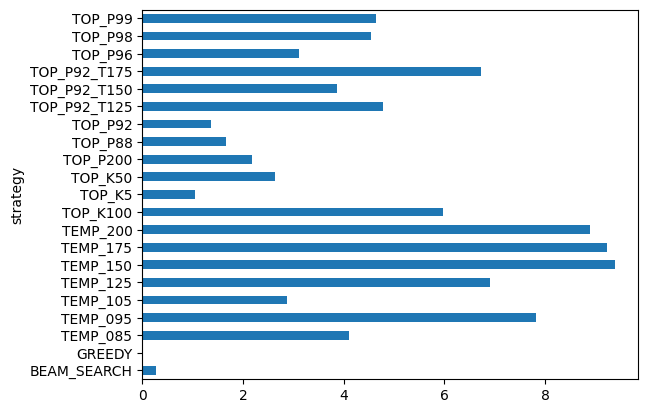

In [6]:
df.delta.groupby("strategy").std().plot.barh()

strategy
BEAM_SEARCH     AxesSubplot(0.125,0.11;0.775x0.77)
GREEDY          AxesSubplot(0.125,0.11;0.775x0.77)
TEMP_085        AxesSubplot(0.125,0.11;0.775x0.77)
TEMP_095        AxesSubplot(0.125,0.11;0.775x0.77)
TEMP_105        AxesSubplot(0.125,0.11;0.775x0.77)
TEMP_125        AxesSubplot(0.125,0.11;0.775x0.77)
TEMP_150        AxesSubplot(0.125,0.11;0.775x0.77)
TEMP_175        AxesSubplot(0.125,0.11;0.775x0.77)
TEMP_200        AxesSubplot(0.125,0.11;0.775x0.77)
TOP_K100        AxesSubplot(0.125,0.11;0.775x0.77)
TOP_K5          AxesSubplot(0.125,0.11;0.775x0.77)
TOP_K50         AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P200        AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P88         AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P92         AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P92_T125    AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P92_T150    AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P92_T175    AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P96         AxesSubplot(0.125,0.11;0.775x0.77)
TOP_P98         AxesSu

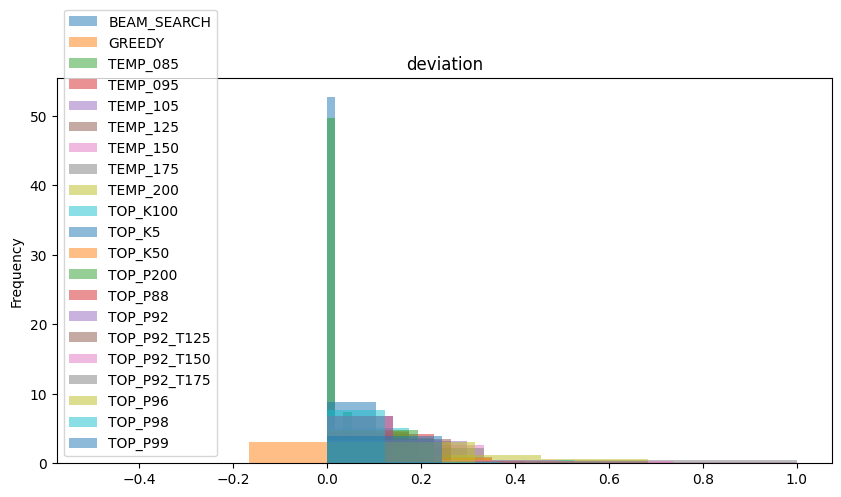

In [7]:
# normalize the DataFrame delta by the maximum temperature deviation
# and drop the rows with no deviation as they are the overwhelming majority of the samples
normalized: pd.Series = df.delta.where(df.delta < 20).dropna()
normalized = normalized / normalized.max()
# plot a distribution of the of the deviation labeled by the strategy
normalized.groupby("strategy").plot.hist(
    title="deviation",
    bins=3,
    alpha=0.5, 
    legend={"loc": "best"},
    figsize=(10, 5),
    density=True,
)

icao
KADW    AxesSubplot(0.125,0.11;0.775x0.77)
KBLV    AxesSubplot(0.125,0.11;0.775x0.77)
KDAA    AxesSubplot(0.125,0.11;0.775x0.77)
KDOV    AxesSubplot(0.125,0.11;0.775x0.77)
KFAF    AxesSubplot(0.125,0.11;0.775x0.77)
KFFO    AxesSubplot(0.125,0.11;0.775x0.77)
KFTK    AxesSubplot(0.125,0.11;0.775x0.77)
KGUS    AxesSubplot(0.125,0.11;0.775x0.77)
KHOP    AxesSubplot(0.125,0.11;0.775x0.77)
KLFI    AxesSubplot(0.125,0.11;0.775x0.77)
KMTC    AxesSubplot(0.125,0.11;0.775x0.77)
KMUI    AxesSubplot(0.125,0.11;0.775x0.77)
KRDR    AxesSubplot(0.125,0.11;0.775x0.77)
KWRI    AxesSubplot(0.125,0.11;0.775x0.77)
PABI    AxesSubplot(0.125,0.11;0.775x0.77)
PAFB    AxesSubplot(0.125,0.11;0.775x0.77)
PASY    AxesSubplot(0.125,0.11;0.775x0.77)
VCSH    AxesSubplot(0.125,0.11;0.775x0.77)
Name: delta, dtype: object

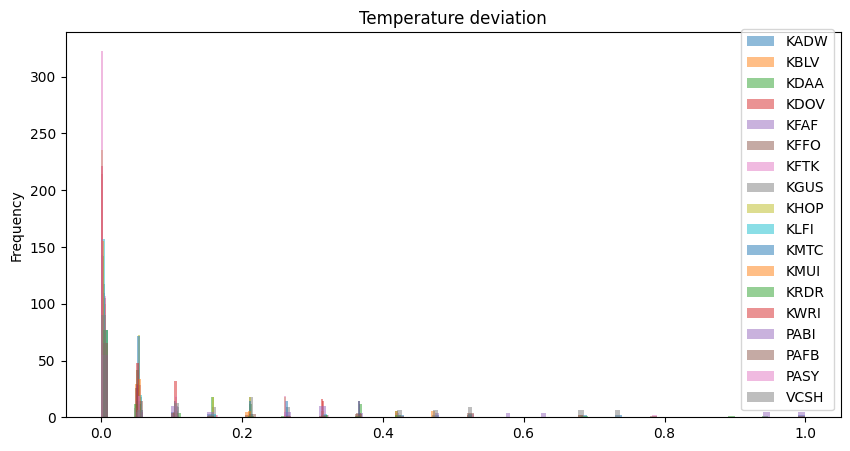

In [8]:
normalized.groupby("icao").plot.hist(
    title="Temperature deviation",
    bins=100,
    alpha=0.5,
    legend={"loc": "best"},
    figsize=(10, 5),
    density=True,
)

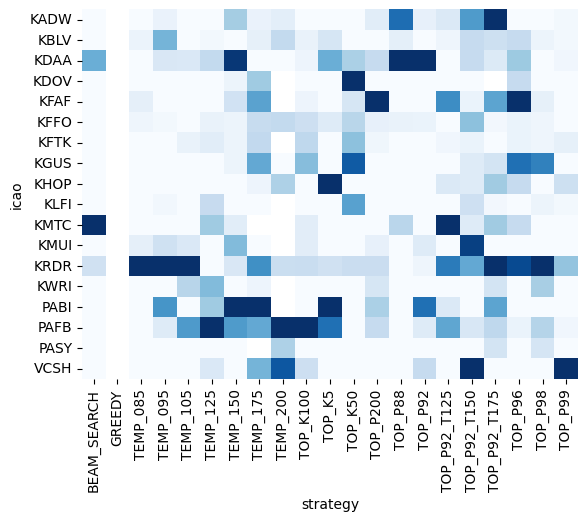

In [9]:
import seaborn as sns


def plot_heatmap(df: pd.DataFrame, title: str):
    # df = df.pivot_table(index="icao", columns="strategy", values="delta")
    # df = df.where(df < 20).dropna()
    df = df / df.max()
    sns.heatmap(df, cmap="Blues", cbar=False)


df.pivot_table(index="icao", columns="strategy", values="delta").pipe(
    plot_heatmap, "Temperature deviation"
)

In [10]:
for index, frame in df.sample(20).iterrows():
    print(
        (frame.prompt + "... " + frame.completion),
        frame[
            [
                "prompt_TX",
                "completion_TX",
                "delta_TX",
                "prompt_TN",
                "completion_TN",
                "delta_TN",
            ]
        ],
        sep="\n",
    )
    print()

TAF [TX19 TN09] AMD KFTK 011405Z 0114/0217 24005KT 9999...  OVC010 620108 QNH2996INS
BECMG 0123/0124 VRB06KT 9999 SCT010 BKN030 QNH2999INS
BECMG 0212/0213 VRB06KT 9999 SCT015 BKN025 QNH3000INS
BECMG 0217/0218 VRB06KT 9999 SCT030 BKN200 QNH3012INS
BECMG 0223/0224 VRB06KT 9999 BKN025 QNH3002INS TX19/0120Z TN09/0212Z
prompt_TX        19.0
completion_TX    19.0
delta_TX          0.0
prompt_TN         9.0
completion_TN     9.0
delta_TN          0.0
Name: (TOP_P88, KFTK), dtype: object

TAF [TXM01 TNM07] AMD KRDR 092100Z 0921/1024 36010G20KT 8000 -SN OVC009...  620097 QNH3005INS TXM05/0917Z TNM06/1008 0620030G25KT TXM12/0617Z
prompt_TX       -1.0
completion_TX   -5.0
delta_TX         4.0
prompt_TN       -7.0
completion_TN   -6.0
delta_TN         1.0
Name: (TEMP_150, KRDR), dtype: object

TAF [TX02 TNM03] KFFO 121100Z 1211/1317 29012KT 9999 BKN022...  510013 QNH3000INS
BECMG 1217/1218 30009KT 9000 BR SCT015 OVC020 510203 QNH2978INS
BECMG 1223/1224 VRB06KT 6000 BR OVC010 WS020/20038KT 510203 Q